# PS bunch generation: LIU 2021, 2022, 2023 Ramp-Up

In [46]:
# General imports
%matplotlib notebook
import sys
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt
from scipy.constants import c

# BLonD imports
sys.path.append('./BLonD')
from blond.beam.beam import Proton, Beam
from blond.input_parameters.ring import Ring
from blond.input_parameters.rf_parameters import RFStation
from blond.trackers.tracker import RingAndRFTracker, FullRingAndRF
from blond.beam.distributions import matched_from_line_density

In [47]:
# Case selection
n_macroparticles = 5e5
beam_selection = 'Standard'
year_selection = 2022

# PS ring parameters
circumference = 2*np.pi*100.
bending_radius = 70.07887
kinetic_energy = 2e9
gamma_t = 6.1

if beam_selection == 'Standard':
    # PS rf parameters Standard
    rf_harmonic = 7

    if year_selection == 2021:
        # PS bunch parameters Standard
        rf_voltage = 42.25e3
        particle_type = Proton()
        full_bunch_length = 135e-9
        # full_emittance = 1.50
        bunch_intensity = 32.50e11
        line_density_type='parabolic_line'

    elif year_selection == 2022:
        # PS bunch parameters Standard
        rf_voltage = 42.60e3
        particle_type = Proton()
        full_bunch_length = 170e-9
        # full_emittance = 2.25
        bunch_intensity = 32.50e11
        line_density_type='parabolic_line'

    elif year_selection == 2023:
        # PS bunch parameters Standard
        rf_voltage = 41.80e3
        particle_type = Proton()
        full_bunch_length = 205e-9
        # full_emittance = 3.00
        bunch_intensity = 32.50e11
        line_density_type='parabolic_line'

# elif beam_selection == 'BCMS':
#     # PS rf parameters BCMS
#     rf_harmonic = 9
#     rf_voltage = 36.55e3

#     # PS bunch parameters BCMS
#     particle_type = Proton()
#     full_bunch_length = 135e-9
#     # full_emittance = 1.48
#     bunch_intensity = 16.25e11
#     line_density_type='parabolic_line'



In [48]:
# Constructing BLonD objects

# Ring object
ring = Ring(circumference, 1/gamma_t**2.,
            kinetic_energy, particle_type,
            synchronous_data_type='kinetic energy')

# RF object
rf_station = RFStation(ring, rf_harmonic,
                       rf_voltage, np.pi)

# Beam object
beam = Beam(ring, n_macroparticles, bunch_intensity)

# Tracker objects
total_induced = None

longitudinal_tracker = RingAndRFTracker(rf_station, beam,
                                        TotalInducedVoltage=total_induced)

full_tracker = FullRingAndRF([longitudinal_tracker])

# Bunch generation
output_profile = matched_from_line_density(
    beam, full_tracker,
    TotalInducedVoltage=total_induced,
    bunch_length=full_bunch_length,
    line_density_type=line_density_type)[1]

# Conversion
particle_beta = np.sqrt(1-(beam.Particle.mass/(beam.energy+beam.dE))**2.)
particle_z = -(beam.dt - rf_station.t_rf[0,0]/2.)*particle_beta*c


In [49]:
# Using blond_common to verify separatrix and emittance

from blond_common.rf_functions.potential import (
    rf_potential_generation, find_potential_wells_cubic,
    potential_well_cut_cubic, trajectory_area_cubic)

n_points = 1000
t_rev = ring.t_rev[0]
eta_0 = ring.eta_0[0,0]
tot_energy = ring.energy[0,0]
beta_rel = ring.beta[0,0]
charge = ring.Particle.charge
energy_increment = ring.delta_E[0]
voltage = rf_station.voltage[0,0]
harmonic = rf_station.harmonic[0,0]
phi_rf = rf_station.phi_rf[0,0]


# Separatrix trajectory
time_bounds_sep = [output_profile[0][0],
                   output_profile[0][-1]]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds_sep)

potwell_max_locs = find_potential_wells_cubic(
    time_array, rf_potential_array)[0]

time_array_list, potential_well_list = potential_well_cut_cubic(
    time_array, rf_potential_array, potwell_max_locs)

(time_sep, dEsep, hamiltonian, calc_area_sep,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array_list[0], potential_well_list[0],
    eta_0, beta_rel, tot_energy)


# Outter bunch trajectory
time_bounds_bunch = [np.min(output_profile[0][output_profile[1]!=0.]),
                     np.max(output_profile[0][output_profile[1]!=0.])]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds_bunch)

potwell_max_locs = find_potential_wells_cubic(
    time_array, rf_potential_array)[0]

(time_bunch, dEbunch, hamiltonian, calc_area_bunch,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array, rf_potential_array,
    eta_0, beta_rel, tot_energy)



/home/HR/Documents/PS_LIU_Tunespread/00_From_Alex/Ramp_Up/blond_common/rf_functions/potential.py:451: RuntimeWarning: invalid value encountered in sqrt
  dEtraj = np.sqrt((potential_array[0]-potential_array) / eom_factor_dE)


<IPython.core.display.Javascript object>


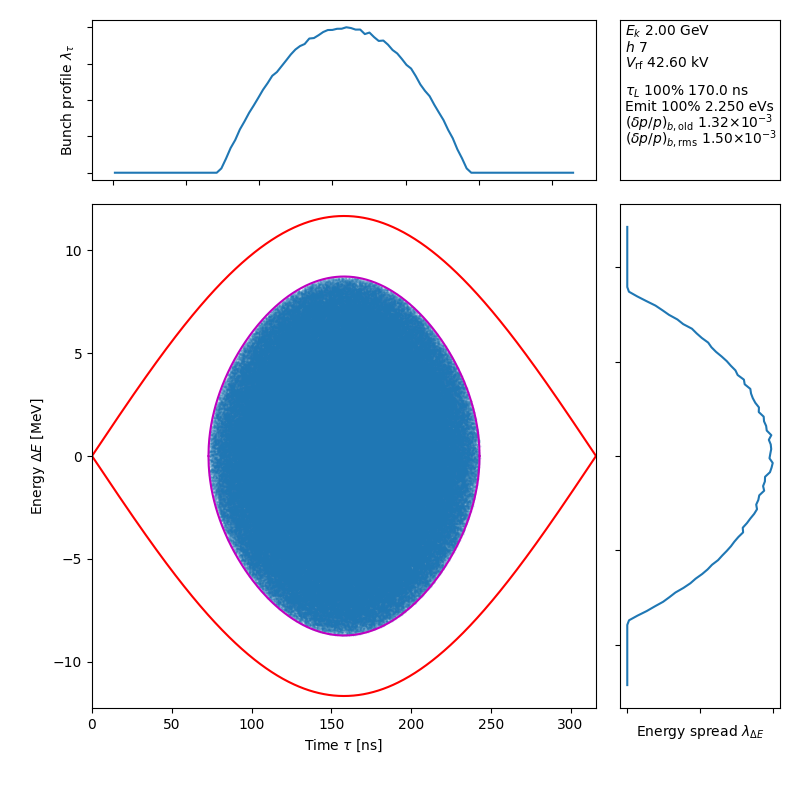

In [50]:
from support_functions import plotPhaseSpace


plotPhaseSpace([beam.dt*1e9, beam.dE/1e6], figname='Beam',
               xbins=100, ybins=100,
               alpha=0.2, markersize=1,
               xlim=(0, rf_station.t_rf[0,0]*1e9),
               ylim=(-1.05*np.max(dEsep)/1e6, 1.05*np.max(dEsep)/1e6))

plt.plot(time_bunch*1e9, dEbunch/1e6, 'm')
plt.plot(time_bunch*1e9, -dEbunch/1e6, 'm')
plt.plot(time_sep*1e9, dEsep/1e6, 'r')
plt.plot(time_sep*1e9, -dEsep/1e6, 'r')

left, width = 0.115, 0.63
bottom, height = 0.115, 0.63
bottom_h = left_h = left+width+0.03
rect_txtBox= [left_h, bottom_h, 0.2, 0.2]
txtBox = plt.axes(rect_txtBox)
txtBox.axes.get_xaxis().set_ticks([])
txtBox.axes.get_yaxis().set_ticks([])
    
txtBox.axes.text(0.03,0.9,'$E_k$ %.2f GeV'%(kinetic_energy/1e9))
txtBox.axes.text(0.03,0.8,'$h$ %d'%(rf_harmonic))
txtBox.axes.text(0.03,0.7,'$V_{\\mathrm{rf}}$ %.2f kV'%(rf_voltage/1e3))
txtBox.axes.text(0.03,0.53,'$\\tau_L$ 100%% %.1f ns'%(full_bunch_length*1e9))
txtBox.axes.text(0.03,0.43,'Emit 100%% %.3f eVs'%(calc_area_bunch))
# txtBox.axes.text(0.03,0.33,'$\\Delta E_{B}$ %.2f MeV'%(np.max(dEsep)/1e6))
# txtBox.axes.text(0.03,0.23,'$(\\delta p/p)_{B,\\mathrm{max}}$ %.2f$\\times 10^{-3}$ '%(np.max(dEsep)/ring.energy[0,0]/ring.beta[0,0]**2.*1e3))
# txtBox.axes.text(0.03,0.23,'$(\\delta p/p)_{b,\\mathrm{max}}$ %.2f$\\times 10^{-3}$ '%(np.max(dEbunch)/ring.energy[0,0]/ring.beta[0,0]**2.*1e3))
txtBox.axes.text(0.03,0.33,'$(\\delta p/p)_{b,\\mathrm{old}}$ %.2f$\\times 10^{-3}$ '%(np.max(dEbunch)/ring.energy[0,0]/ring.beta[0,0]**2.*1e3 /2*0.8))
txtBox.axes.text(0.03,0.23,'$(\\delta p/p)_{b,\\mathrm{rms}}$ %.2f$\\times 10^{-3}$ '%(np.std(beam.dE/ring.energy[0,0]/particle_beta**2.)*1e3))
plt.savefig('figure_'+str(beam_selection)+'_'+str(year_selection)+'.png')


### Turn data into 2D heatmap

<IPython.core.display.Javascript object>


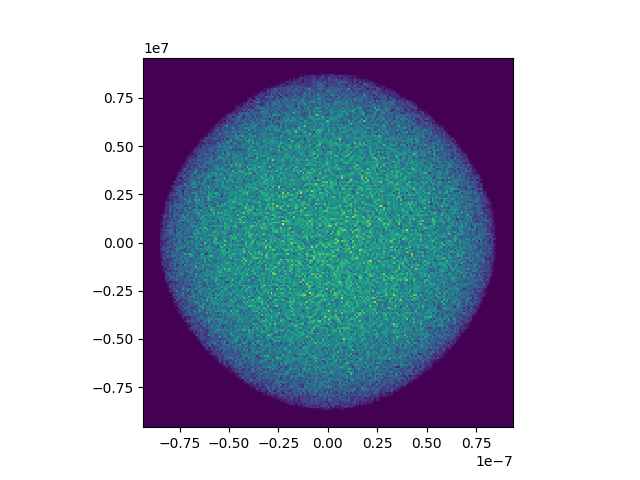

In [51]:
# First we need to make the data into a 2D array

# Start with our data
dE = np.array(beam.dE)
dt = np.array((beam.dt - rf_station.t_rf[0,0]/2.))

bin_size_x = 200
bin_size_y = 200
x_min = np.min(dt)*1.1
x_max = np.max(dt)*1.1
y_min = np.min(dE)*1.1
y_max = np.max(dE)*1.1

# Need a heatmap to make a 2D array:
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

heatmap, xedges, yedges = np.histogram2d(dt, dE, bins=(bin_size_x, bin_size_y), range=[[x_min, x_max],[y_min, y_max]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax1.imshow(heatmap, extent=extent, aspect=( (x_min - x_max)/(y_min - y_max) ) )

<IPython.core.display.Javascript object>


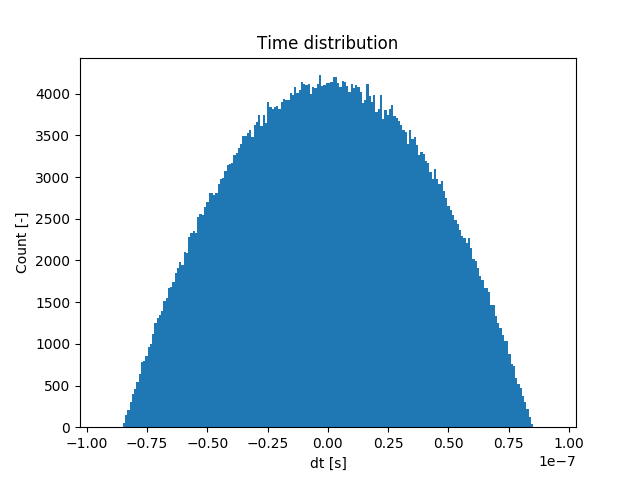

[Text(0, 0.5, 'Count [-]'),
 Text(0.5, 0, 'dt [s]'),
 Text(0.5, 1.0, 'Time distribution')]

In [52]:
# Check parabolic structure is maintained
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

hist, bin_edges = np.histogram(dt, bins = bin_size_x, range=[x_min, x_max])
plt.hist(dt, bins = bin_size_x, range=[x_min, x_max])

ax1.set(xlabel='dt [s]', ylabel='Count [-]', title='Time distribution')

<IPython.core.display.Javascript object>


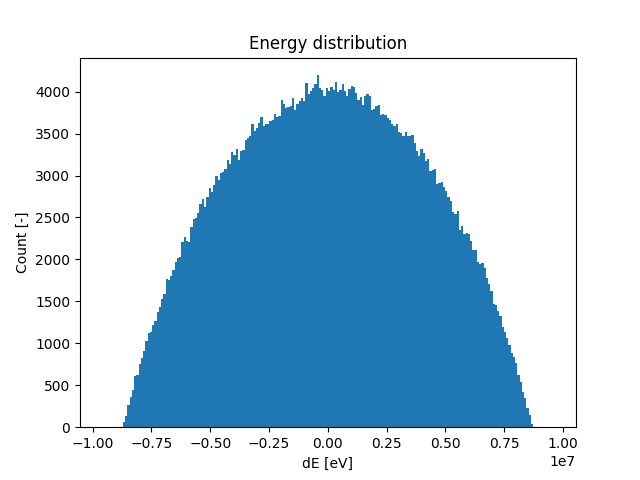

[Text(0, 0.5, 'Count [-]'),
 Text(0.5, 0, 'dE [eV]'),
 Text(0.5, 1.0, 'Energy distribution')]

In [53]:
# Check parabolic structure is maintained
# Create heatmap
fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

hist, bin_edges = np.histogram(dE, bins = bin_size_y, range=[y_min, y_max])
plt.hist(dE, bins = bin_size_y, range=[y_min, y_max])

ax1.set(xlabel='dE [eV]', ylabel='Count [-]', title='Energy distribution')

## Write tomo-style PyORBIT input file

In [54]:
# Save file for PyORBIT - Format 1 (untested)
use_txt_file = False
if use_txt_file:
    fname = str('PyORBIT_Tomo_file_' + beam_selection + '.txt')

    thefile = open(fname,"w")

    # First line: Minimum dt, maximum dt, binsize, bins (nanoseconds)
    thefile.write("%f\t%f\t%f\t%i" % (xedges[0]*1E9, xedges[-1]*1E9, np.abs(xedges[1]-xedges[0])*1E9, len(xedges)))

    # Second line: Minimum dE, maximum dE, binsize, bins (MeV)
    thefile.write("\n%f\t%f\t%f\t%i" % (yedges[0]*1E-6, yedges[-1]*1E-6, np.abs(yedges[1]-yedges[0])*1E-6, len(yedges)))

    # Write density as grid
    thefile.write("\n")
    data = heatmap

    for x in np.arange(len(xedges)-1):
        for y in np.arange(len(yedges)-1):
            thefile.write("%1.10f\t" % (heatmap[x, y]))
        thefile.write("\n")
    thefile.close()

In [55]:
# We want this in units of MeV and ns
data = heatmap
data_dict = {'time_nsec': xedges*1E9, 'energy_MeV': yedges*1E-6, 'density_array': data}
fname = str('PyORBIT_Tomo_file_LIU_Ramp_Up_' + beam_selection +'_'+ str(year_selection) + '.mat')
savemat(fname, data_dict)

In [28]:
# Saving distribution
save_z = False
if save_z:
    np.savez('distribution_'+str(beam_selection)+'_'+str(year_selection)+'.npz',
             dt=(beam.dt - rf_station.t_rf[0,0]/2.),
             dz=particle_z,
             dE=beam.dE)

